# Chlorophyll -a pre-processing
Reprojection, smoothing and interpolation of chla data on UTM33N grid with 4x4km resolution.


In [1]:
# print name of the current environment
import os
print(os.environ.get('CONDA_DEFAULT_ENV'))

geo


In [2]:
# import libraries for working with .nc
import xarray as xr
import os   
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import dask 
import random
import glob

import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata
from pyproj import Proj, Transformer
import geopandas
from shapely.geometry import Point



I skip the coarsening step (in previous version of the repo).


In [3]:
# origin path
pathDEST = '/mnt/d/Dropbox/R_projects/SVpheno/data/CDS/daily_smoothed'
pathCOARS =  '/mnt/d/Dropbox/R_projects/SV_phenology/data/CDS/daily_area'

In [4]:
# create the folder
# se non esiste creo la cartella
if not os.path.exists(pathDEST):
    os.makedirs(pathDEST)

In [5]:
year = 2004
ds = xr.open_mfdataset(f"{pathCOARS}/{year}/*.nc", combine='by_coords')
# project to utm
ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ds.rio.write_crs("epsg:4326", inplace=True)

# Re-proietta in UTM 33N
ds_utm33n = ds.rio.reproject("epsg:32633", resolution = 4000)

In [7]:
# drop all variables vut chlor_a
ds_sel = ds_utm33n.drop(['MERIS_nobs', 'MODISA_nobs', 'OLCI-A_nobs', 'OLCI-B_nobs', 'SeaWiFS_nobs', 'VIIRS_nobs', 'total_nobs', 'crs'])

In [8]:
ds_sel

<xarray.Dataset>
Dimensions:      (x: 456, y: 388, time: 245)
Coordinates:
  * x            (x) float64 -1.764e+05 -1.724e+05 ... 1.64e+06 1.644e+06
  * y            (y) float64 9.538e+06 9.534e+06 9.53e+06 ... 7.994e+06 7.99e+06
  * time         (time) datetime64[ns] 2004-03-01 2004-03-02 ... 2004-10-31
    spatial_ref  int64 0
Data variables:
    chlor_a      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/45)
    Conventions:                    CF-1.7
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date:                  20220517T213804Z
    creator_email:                  help@esa-oceancolour-cci.org
    ...                             ...
    time_coverage_start:            200403010000Z
    title:                          Copernicus Climate Change Service Ocean C...
    tracking_id:                    630190af-42c4-4ab8-b075-ba7993b17858
    NCO:                            netCDF Operators version 4.7.5 (Homepage ...
    id:                             ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km...
    summary:                        Data products generated for C3S using the...

In [9]:
ds_smooth_temporal = ds_sel.rolling(time=3, center=True, min_periods=1).mean()
ds_smooth_spatial = ds_smooth_temporal.rolling(x=3, center=True, min_periods=1).mean().rolling(y=3, center=True, min_periods=1).mean()
ds_3w = ds_smooth_spatial.rolling(time=21, center=True, min_periods=1).mean()


effect of the smoothing on the data:

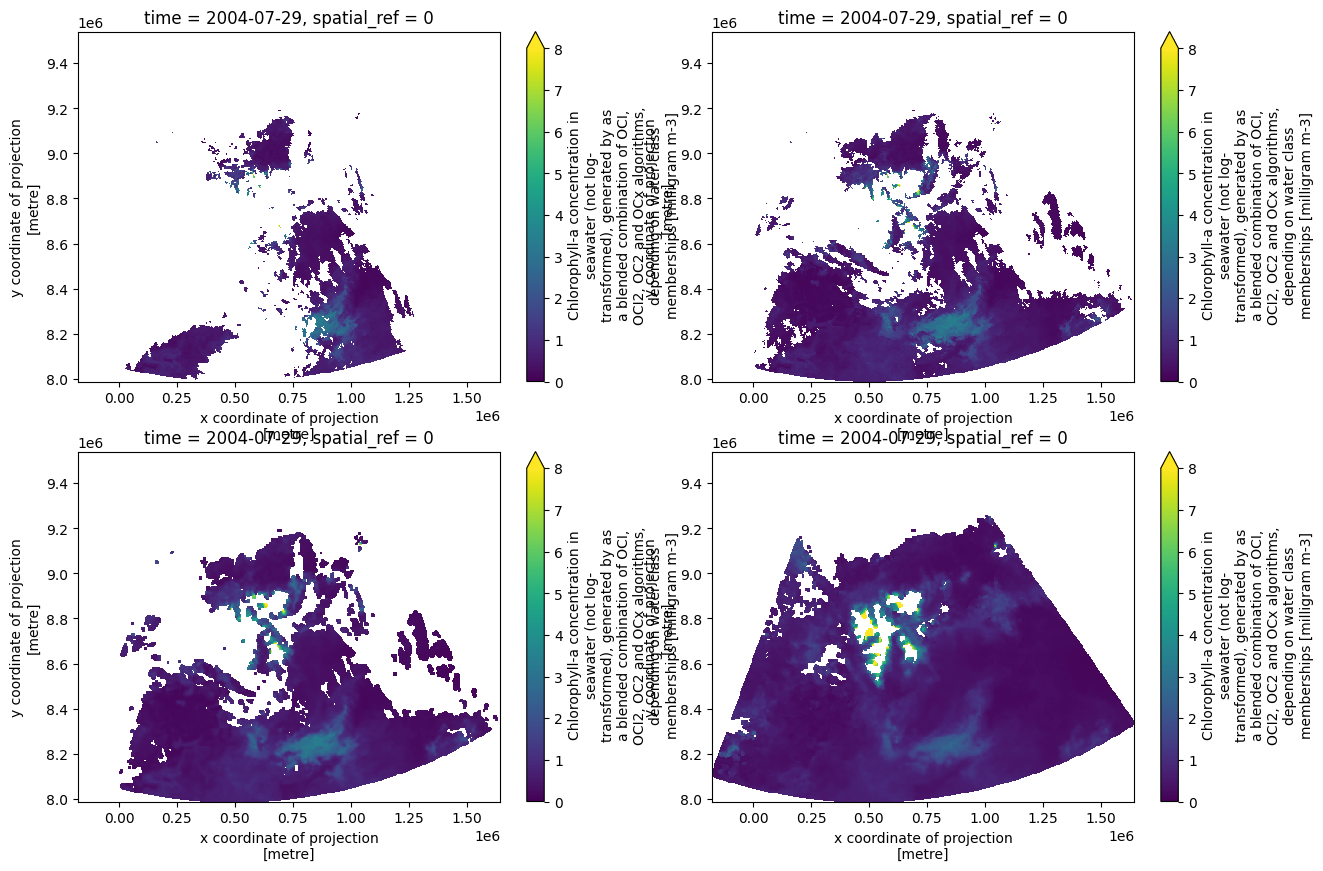

In [10]:
# nuovo xarray con il time = 25 per ds_sel, ds_smooth_temporal, ds_smooth_spatial, ds_3w
ds_sel25 = ds_sel.isel(time = 150)
ds_smooth_temporal25 = ds_smooth_temporal.isel(time = 150)
ds_smooth_spatial25 = ds_smooth_spatial.isel(time = 150)
ds_3w25 = ds_3w.isel(time = 150)

# plot
vmin, vmax = 0, 8

fig, ax = plt.subplots(2,2, figsize = (15,10))
ds_sel25.chlor_a.plot(ax = ax[0,0], vmin=vmin, vmax=vmax)
ds_smooth_temporal25.chlor_a.plot(ax = ax[0,1], vmin=vmin, vmax=vmax)
ds_smooth_spatial25.chlor_a.plot(ax = ax[1,0], vmin=vmin, vmax=vmax)
ds_3w25.chlor_a.plot(ax = ax[1,1], vmin=vmin, vmax=vmax)


In [11]:

weights = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 10, 9 , 8, 7, 6, 5, 4, 3, 2, 1]
weights = weights/np.sum(weights)

It would be interesting to d rolling mean, as from:
https://stackoverflow.com/questions/48510784/xarray-rolling-mean-with-weights


In [144]:

# Definisci i pesi per la finestra di 21 giorni
window_length = 21
#weights = np.ones(window_length) / window_length  # Pesos de media simple para el ejemplo
weights_xr = xr.DataArray(weights, dims=["window"])

ds_chunked = ds_smooth_spatial.chunk({'time': -1, 'x': 20, 'y': 20})

# Crea la finestra rolling e costruisci le finestre
rolling_windows = ds_chunked.rolling(time=window_length, center=True, min_periods=1).construct("window_dim")

# Calcola la media ponderata
# Moltiplica ogni finestra per i pesi e poi somma lungo la dimensione della finestra
weighted_mean = (rolling_windows * weights_xr).sum(dim="window_dim") 


In [128]:
weighted_mean

<xarray.Dataset>
Dimensions:      (x: 456, y: 388, time: 245, window: 21)
Coordinates:
  * x            (x) float64 -1.764e+05 -1.724e+05 ... 1.64e+06 1.644e+06
  * y            (y) float64 9.538e+06 9.534e+06 9.53e+06 ... 7.994e+06 7.99e+06
  * time         (time) datetime64[ns] 2004-03-01 2004-03-02 ... 2004-10-31
    spatial_ref  int64 0
Dimensions without coordinates: window
Data variables:
    chlor_a      (time, y, x, window) float64 dask.array<chunksize=(244, 20, 20, 21), meta=np.ndarray>

In [145]:
weighted_mean_without_window = weighted_mean.mean(dim='window').compute()


In [146]:
weighted_mean_without_window

<xarray.Dataset>
Dimensions:      (x: 456, y: 388, time: 244)
Coordinates:
  * x            (x) float64 -1.764e+05 -1.724e+05 ... 1.64e+06 1.644e+06
  * y            (y) float64 9.538e+06 9.534e+06 9.53e+06 ... 7.994e+06 7.99e+06
  * time         (time) datetime64[ns] 1998-03-01 1998-03-02 ... 1998-10-31
    spatial_ref  int64 0
Data variables:
    chlor_a      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

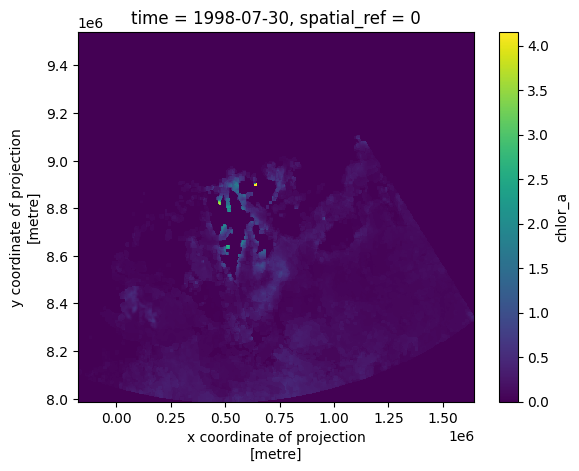

In [149]:
weighted_mean_without_window.chlor_a.isel(time = 150).plot()

In [85]:
rollingW = weighted_mean.isel(time = 150)
# set x and y as coordinates
r

In [115]:
ds_calc = weighted_mean.compute()

(array([3.644189e+06, 5.601600e+04, 1.016700e+04, 2.623000e+03,
        1.129000e+03, 6.090000e+02, 3.170000e+02, 2.340000e+02,
        1.540000e+02, 5.000000e+01]),
 array([   0.        ,  175.56123409,  351.12246819,  526.68370228,
         702.24493637,  877.80617046, 1053.36740456, 1228.92863865,
        1404.48987274, 1580.05110683, 1755.61234093]),
 <BarContainer object of 10 artists>)

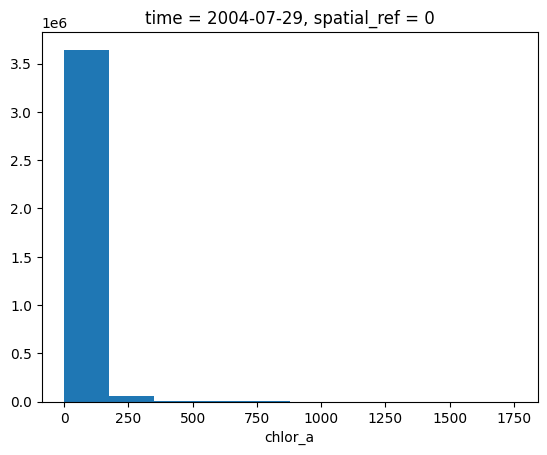

In [123]:
ds_red.chlor_a.isel(time=150).plot()

In [104]:
dwr25 = ds_reduced_computed.isel(time = 150)
# set all values that are NaN in ds_3w25 as Nan in dwr25
dwr25 = dwr25.where(ds_3w25.chlor_a >= 0)

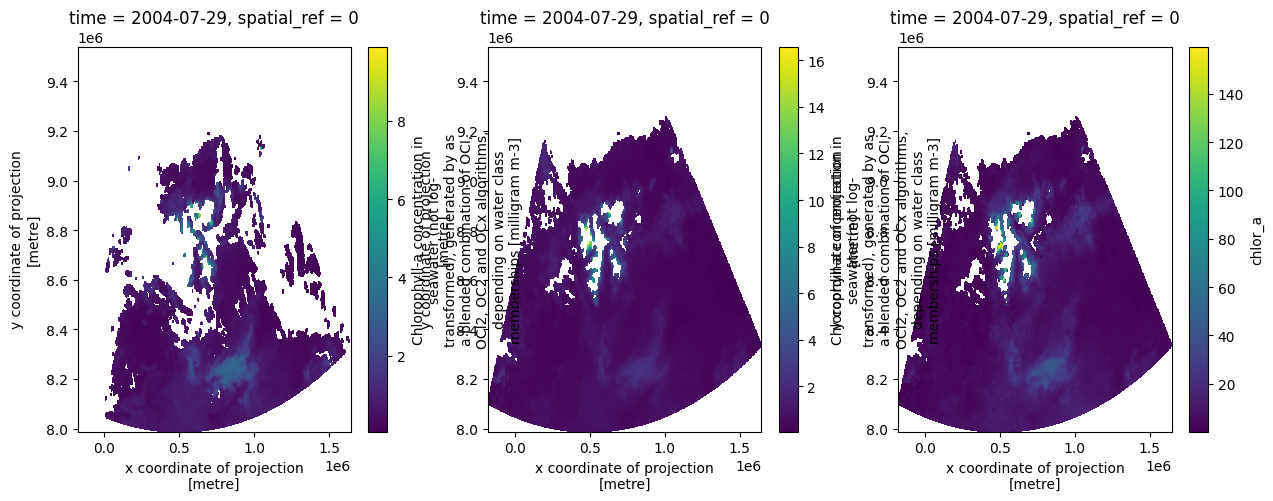

In [106]:
# plot ds_3w25 and dwr25
fig, ax = plt.subplots(1,3, figsize = (15,5))
ds_smooth_spatial25.chlor_a.plot(ax = ax[0])
ds_3w25.chlor_a.plot(ax = ax[1])
dwr25.chlor_a.plot(ax = ax[2])

In [95]:
rollingW


<xarray.Dataset>
Dimensions:      (x: 456, y: 388, window: 21)
Coordinates:
  * x            (x) float64 -1.764e+05 -1.724e+05 ... 1.64e+06 1.644e+06
  * y            (y) float64 9.538e+06 9.534e+06 9.53e+06 ... 7.994e+06 7.99e+06
    time         datetime64[ns] 2004-07-29
    spatial_ref  int64 0
Dimensions without coordinates: window
Data variables:
    chlor_a      (y, x, window) float64 dask.array<chunksize=(20, 20, 21), meta=np.ndarray>

## Remove lands

use the shapefile as a mask to remove the land from the data.

<Axes: >

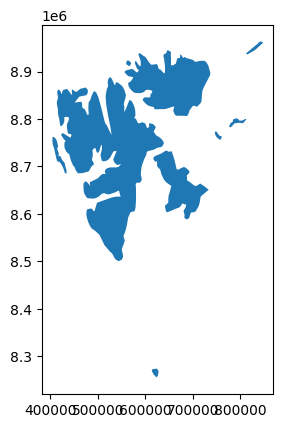

In [12]:
# load "D:\Dropbox\R_projects\svalbaRd\data\Svalbard_UTM.shp"
filepath = "/mnt/d/Dropbox/R_projects/svalbaRd/" + "data/Svalbard_UTM.shp"


# read the shapefile
gdf = geopandas.read_file(filepath)
#plot   
gdf.plot()

In [13]:
template_ds = ds_3w.isel(time=0)  # Assumendo che ds_3w sia il tuo dataset xarray

# Crea un raster binario dalla geometria dello shapefile
transform = rasterio.transform.from_bounds(*template_ds.rio.bounds(), template_ds.dims['x'], template_ds.dims['y'])
out_shape = (template_ds.dims['y'], template_ds.dims['x'])
rasterized = rasterio.features.rasterize(gdf.geometry, out_shape=out_shape, fill=0, transform=transform, all_touched=True)
mask = xr.DataArray(rasterized, dims=('y', 'x'))

# Applica la maschera al dataset
ds_masked = ds_3w25.where(mask == 0)

<Axes: title={'center': 'time = 2004-07-29, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

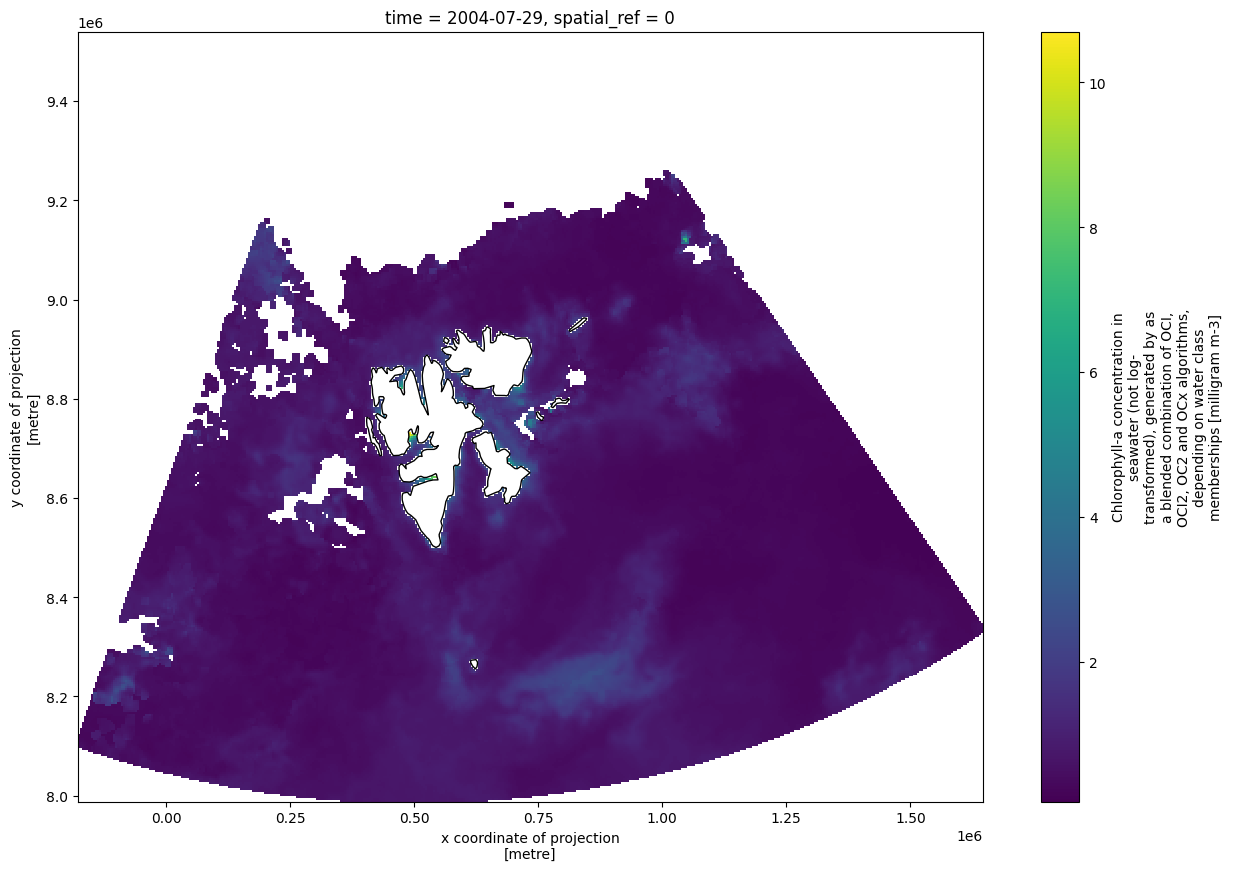

In [14]:

# plot ds_3w25.chlor_a.plot(ax = ax[1,1]) with the shapefile
fig, ax = plt.subplots(1,1, figsize = (15,10))
ds_masked.chlor_a.plot(ax = ax)
gdf.plot(ax = ax, facecolor="none", edgecolor='black')

# forloop for data processing

In [15]:
ds_smooth_spatial

<xarray.Dataset>
Dimensions:      (x: 456, y: 388, time: 245)
Coordinates:
  * x            (x) float64 -1.764e+05 -1.724e+05 ... 1.64e+06 1.644e+06
  * y            (y) float64 9.538e+06 9.534e+06 9.53e+06 ... 7.994e+06 7.99e+06
  * time         (time) datetime64[ns] 2004-03-01 2004-03-02 ... 2004-10-31
    spatial_ref  int64 0
Data variables:
    chlor_a      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/45)
    Conventions:                    CF-1.7
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date:                  20220517T213804Z
    creator_email:                  help@esa-oceancolour-cci.org
    ...                             ...
    time_coverage_start:            200403010000Z
    title:                          Copernicus Climate Change Service Ocean C...
    tracking_id:                    630190af-42c4-4ab8-b075-ba7993b17858
    NCO:                            netCDF Operators version 4.7.5 (Homepage ...
    id:                             ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km...
    summary:                        Data products generated for C3S using the...

In [17]:
# Inizializza un dataset vuoto per i dati interpolati
ds_smooth_tot = None
ystart = 2014
for year in range(ystart, 2023):
    print(f"Processing year: {year}")
    ds = xr.open_mfdataset(f"{pathCOARS}/{year}/*.nc", combine='by_coords')

    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)

    # Re-proietta in UTM 33N
    ds_utm33n = ds.rio.reproject("epsg:32633", resolution = 4000)
    
    # remove unused variables
    ds_sel = ds_utm33n.drop(['MERIS_nobs', 'MODISA_nobs', 'OLCI-A_nobs', 'OLCI-B_nobs', 'SeaWiFS_nobs', 'VIIRS_nobs', 'total_nobs', 'crs'])
    
    #3d smoothing + 21 days rolling weighted_mean
    ds_smooth_temporal = ds_sel.rolling(time=3, center=True, min_periods=1).mean()
    ds_smooth_spatial = ds_smooth_temporal.rolling(x=3, center=True, min_periods=1).mean().rolling(y=3, center=True, min_periods=1).mean()
    ds_3w = ds_smooth_spatial.rolling(time=21, center=True, min_periods=1).mean()

    # mask land
    ds_3w = ds_3w.where(mask == 0)
    
    
    # append to a new dataset
    if year == ystart:
        ds_smooth_tot = ds_3w
    else:
        ds_smooth_tot = xr.concat([ds_smooth_tot, ds_3w], dim='time')

    # save the dataset
    pathDEST_year = pathDEST + '/' + str(year)
    if not os.path.exists(pathDEST_year):
        os.makedirs(pathDEST_year)
        
    for month in range(3, 11):
        
        # seleziono i dati per il mese e l'anno
        ds_month_year = ds_3w.sel(time=(ds_3w.time.dt.year == year) & (ds_3w.time.dt.month == month))
        
        #salvo il file mensile
        ds_month_year.to_netcdf(pathDEST_year + '/' + 'CDS_smoothed_' + str(year) + '_' + str(month) + '.nc')
        
        print('saved ' + str(year) + '_' + str(month) + '.nc')
    
    
    


Processing year: 2014
saved 2014_3.nc
saved 2014_4.nc
saved 2014_5.nc
saved 2014_6.nc
saved 2014_7.nc
saved 2014_8.nc
saved 2014_9.nc
saved 2014_10.nc
Processing year: 2015
saved 2015_3.nc
saved 2015_4.nc
saved 2015_5.nc
saved 2015_6.nc
saved 2015_7.nc
saved 2015_8.nc
saved 2015_9.nc
saved 2015_10.nc
Processing year: 2016
saved 2016_3.nc
saved 2016_4.nc
saved 2016_5.nc
saved 2016_6.nc
saved 2016_7.nc
saved 2016_8.nc
saved 2016_9.nc
saved 2016_10.nc
Processing year: 2017
saved 2017_3.nc
saved 2017_4.nc
saved 2017_5.nc
saved 2017_6.nc
saved 2017_7.nc
saved 2017_8.nc
saved 2017_9.nc
saved 2017_10.nc
Processing year: 2018
saved 2018_3.nc
saved 2018_4.nc
saved 2018_5.nc
saved 2018_6.nc
saved 2018_7.nc
saved 2018_8.nc
saved 2018_9.nc
saved 2018_10.nc
Processing year: 2019
saved 2019_3.nc
saved 2019_4.nc
saved 2019_5.nc
saved 2019_6.nc
saved 2019_7.nc
saved 2019_8.nc
saved 2019_9.nc
saved 2019_10.nc
Processing year: 2020
saved 2020_3.nc
saved 2020_4.nc
saved 2020_5.nc
saved 2020_6.nc
saved 20

In [130]:
pathDEST + '/' + str(year)

'/mnt/d/Dropbox/R_projects/SVpheno/data/CDS/daily_smoothed/2004'

# save climatology

ave_smooth_tot = ds_smooth_tot.groupby('time.dayofyear').mean(dim='time')



In [20]:
ds_smooth_tot = None
ystart = 1998

# load all the files in ds_smooth_tot
for year in range(ystart, 2023):
    pathDEST_year = pathDEST + '/' + str(year)
    ds_year = xr.open_mfdataset(f"{pathDEST_year}/*.nc", combine='by_coords')
    if year == ystart:
        ds_smooth_tot = ds_year
    else:
        ds_smooth_tot = xr.concat([ds_smooth_tot, ds_year], dim='time')
    print(year)

1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


In [21]:
ds_smooth_tot

<xarray.Dataset>
Dimensions:      (time: 6124, y: 388, x: 456)
Coordinates:
  * x            (x) float64 -1.764e+05 -1.724e+05 ... 1.64e+06 1.644e+06
  * y            (y) float64 9.538e+06 9.534e+06 9.53e+06 ... 7.994e+06 7.99e+06
  * time         (time) datetime64[ns] 1998-03-01 1998-03-02 ... 2022-10-31
    spatial_ref  int64 0
Data variables:
    chlor_a      (time, y, x) float32 dask.array<chunksize=(31, 388, 456), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                    CF-1.7
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date:                  20220517T132630Z
    creator_email:                  help@esa-oceancolour-cci.org
    ...                             ...
    time_coverage_start:            199803010000Z
    title:                          Copernicus Climate Change Service Ocean C...
    tracking_id:                    b96aba32-fe16-4850-b3f1-84a72901a6de
    NCO:                            netCDF Operators version 4.7.5 (Homepage ...
    id:                             ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km...
    summary:                        Data products generated for C3S using the...

In [22]:
ave_smooth_tot = ds_smooth_tot.groupby('time.dayofyear').mean(dim='time')
ave_smooth_tot.to_netcdf(pathDEST + '/daily_smoothed_climatology.nc')


In [23]:
ave_smooth_tot

<xarray.Dataset>
Dimensions:      (dayofyear: 246, y: 388, x: 456)
Coordinates:
  * x            (x) float64 -1.764e+05 -1.724e+05 ... 1.64e+06 1.644e+06
  * y            (y) float64 9.538e+06 9.534e+06 9.53e+06 ... 7.994e+06 7.99e+06
    spatial_ref  int64 0
  * dayofyear    (dayofyear) int64 60 61 62 63 64 65 ... 300 301 302 303 304 305
Data variables:
    chlor_a      (dayofyear, y, x) float32 dask.array<chunksize=(1, 388, 456), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                    CF-1.7
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date:                  20220517T132630Z
    creator_email:                  help@esa-oceancolour-cci.org
    ...                             ...
    time_coverage_start:            199803010000Z
    title:                          Copernicus Climate Change Service Ocean C...
    tracking_id:                    b96aba32-fe16-4850-b3f1-84a72901a6de
    NCO:                            netCDF Operators version 4.7.5 (Homepage ...
    id:                             ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km...
    summary:                        Data products generated for C3S using the...

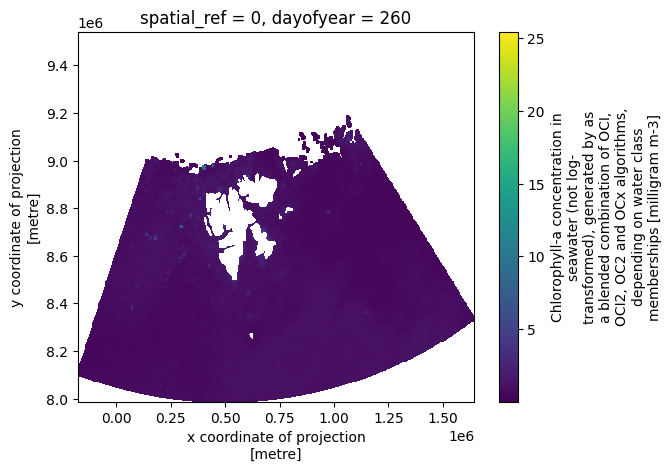

In [27]:
# plot il doy 150 della climatologia
ave_smooth_tot.chlor_a.isel(dayofyear=200).plot()

In [134]:
pathDEST + '/daily_smoothed_climatology.nc'

'/mnt/d/Dropbox/R_projects/SVpheno/data/CDS/daily_smoothed/daily_smoothed.nc'